In [80]:
"""
Script to find area coverage from top-down images of blender AgNW films
31.10.2022
Paul Vautravers
"""
#Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

#### Area Coverage

In [29]:
def thresh_crop(img,thresh_val=40,crop_fr=0.25):
    """
    Function to crop image uniformly by a certain percentage along each axis
    and convert to black and white
    Inputs: img;image to be cropped, thresh_val; pixel value to split into white and black
            crop_fr; fraction each axis should be reduced by
    outputs: thresh; black and white version of initial image and img_cropped;cropped black and white image
    """
    #binary applied
    ret,thresh = cv2.threshold(img,thresh_val,255,cv2.THRESH_BINARY)
    img_shape = np.shape(thresh)
    #binary image cropped along each axis
    img_cropped = thresh[int(img_shape[0]*crop_fr/2):int(img_shape[0]*(1-crop_fr/2)), 
                         int(img_shape[1]*crop_fr/2):int(img_shape[1]*(1-crop_fr/2))]
    
    return thresh,img_cropped

def get_area_coverage(img_in=None,img_path=None,thresh_val=40,crop_fr=0.25,plot=0):
    """
    Function to output area coverage from image of some film, provided either with a path or image
    Inputs: img_in;image to be analysed, img_path; path to desired image; thresh_val and crop_fr; see 'thresh_crop'
            and plot; 0 to not plot, 1 to plot images
    outputs: value of area coverage and can display cropped image
    """
    #images read in
    if img_path!=None:
        img = cv2.imread(img_path,0)
    else:
        img = img_in
    
    #binary and cropping applied
    thresh,img_cropped = thresh_crop(img,thresh_val = thresh_val,crop_fr=crop_fr)
    img_cropped_shape = np.shape(img_cropped)
    
    #count number of white pixels
    pix_count = cv2.countNonZero(img_cropped)
    #calculate fraction of pixels corresponding to wires
    area_coverage = 1 - pix_count/(img_cropped_shape[0]*img_cropped_shape[1])
    
    #images may be plotted
    if plot != 0:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 15))
        ax1.imshow(thresh,'gray',origin='lower')
        ax2.imshow(img_cropped,'gray',origin='lower')
        plt.show()
    
    return area_coverage

def get_ac_array(img_dir_path, thresh_val=40,crop_fr=0.25,plot_hist=0):
    """
    Function to output area coverages for whole input array of images
    Inputs: img_dir_path; path to desired image directory; thresh_val and crop_fr; see 'thresh_crop'
            and plot_hist; 0 to not plot, 1 to plot histogram of area coverages at given parameters
    outputs: returns average area coverage and standard deviation, with area coverage histogram displayed
    """
    #read in images and make empty array for area coverage values
    images = [cv2.imread(file,0) for file in glob.glob(img_dir_path)]
    ac_arr = np.array([])
    for i,img in enumerate(images):
        ac_arr = np.append(ac_arr,get_area_coverage(img_in=img))
    ac_avg = np.mean(ac_arr)
    ac_std = np.std(ac_arr)
    #histogram of area coverages for given input directory can be produced
    if plot_hist != 0:
        
        fig,ax = plt.subplots(figsize=(6,6))
        ac_hist = plt.hist(ac_arr,bins='auto')
        plt.xlabel('Area Coverage')
        plt.ylabel('Number of films')
        plt.show()
    
    return ac_avg,ac_std


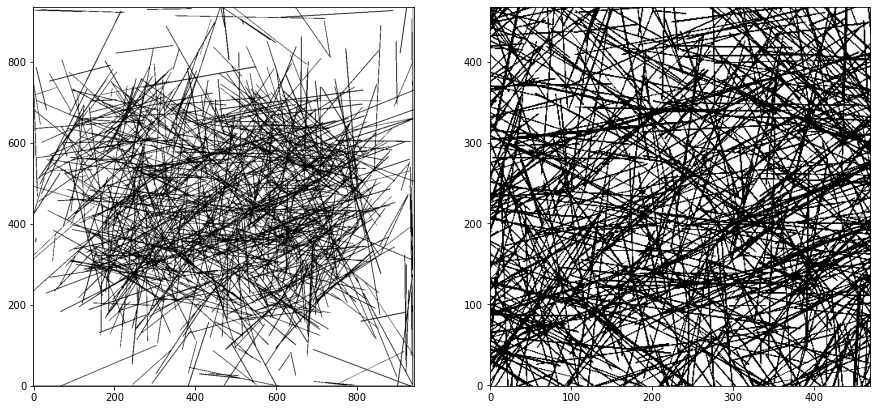

Area Coverage = 0.539148


In [43]:
area_coverage = get_area_coverage(img_path="ac_img_dir/agnw_1000_s30_d_z.png",plot=1,crop_fr=0.5)
print("Area Coverage = {0:f}".format(area_coverage))

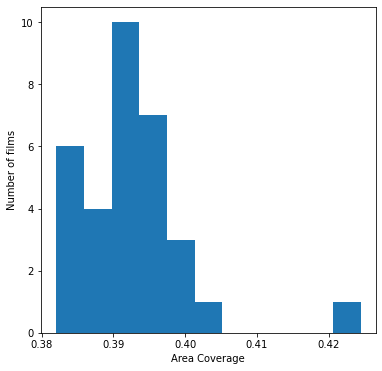

Area Coverage = 0.392494 +- 0.007740


In [47]:
mean_ac,std_ac = get_ac_array("ac_img_dir/*.png",plot_hist=1,crop_fr=0.5)
print("Area Coverage = {0:f} +- {1:f}".format(mean_ac,std_ac))


#### Connected Component Analysis

In [76]:
def get_connected_components(img_in):
    """
    Function to collected connected components from image
    Input: image data, should be binary valued
    Output: tuple with number of components, their IDs, the values and the 
            component centroids
    """
    
    # Apply the Component analysis function
    analysis = cv2.connectedComponentsWithStats(img_in,4,cv2.CV_32S)
    (total_labels, label_ids, values, centroid) = analysis
    
    return (total_labels,label_ids,values,centroid)

def get_areas_cc(img_in,min_area=5,plt_hist=0):
    """
    Function to get the areas of connected components in the initial image
    Inputs: img_in; image to do connected component analysis with, min_area;
            the minimum required area of connected components to be counted and
            plt_hist; 0 or 1 to plot histogram of areas
    Outputs: cc_area_avg;average area of connected components and cc_area_std: standard
            deviation in connected component area
    """
    #retrieve connected component data
    (total_labels,label_ids,values,centroids)=get_connected_components(img_in)
    output = np.zeros(img_in.shape, dtype="uint8")
    areas = np.array([])
    #collect areas, filtered relative to minimum area
    for i in range(total_labels):
        area = values[i, cv2.CC_STAT_AREA]
        if area>min_area:
            areas = np.append(areas,area)
    
    #average and std of areas in question
    #first value omitted as it's the trivial connected component, 
    #i.e. the majority of the film in this case
    cc_area_avg = np.mean(areas[1:])
    cc_area_std = np.std(areas[1:])

    if plt_hist != 0:
        fig,ax = plt.subplots(figsize=(8,8))
        ac_hist = plt.hist(areas[1:],bins='auto')
        plt.xlabel('Connected Component Area (#Pixels)')
        plt.ylabel('Number of Connected Components')
        plt.show()
        
    return cc_area_avg,cc_area_std 

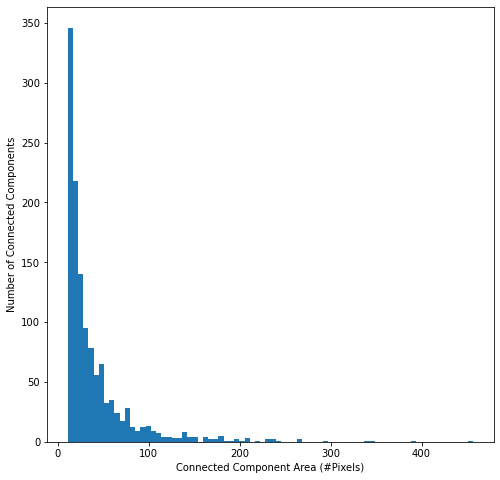

(39.57380952380952, 42.271947767132886)

In [77]:
#Collect example image for connected component
img_cc = cv2.imread("ac_img_dir/agnw_1000_s1_d_z.png",0)
_,img_cc = thresh_crop(img_cc,crop_fr=0.6)
#show histogram of areas from binary of image
get_areas_cc(img_cc,min_area = 10,plt_hist=1)

In [78]:
def plt_cc(img_in,area_min,area_max):
    """
    Function to Plot connected components from cropped binary image
    Inputs: img_in; input image, area_min; lower bound of area to consider and area_max;
            upper bound of area to consider
    Outputs: Plots initial image and image with connected components in area range
    """
    output = np.zeros(img_in.shape, dtype="uint8")
    (total_labels,label_ids,values,centroids)=get_connected_components(img_in)
    for i in range(total_labels):
        area = values[i, cv2.CC_STAT_AREA]
    
        #create mask for areas within desired range
        if area > area_min and area < area_max:
            componentMask = (label_ids == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
    
    #plot initial and restricted image
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
    ax1.imshow(img_in, vmin = 0, vmax =255)
    ax2.imshow(output)
    plt.show()
    

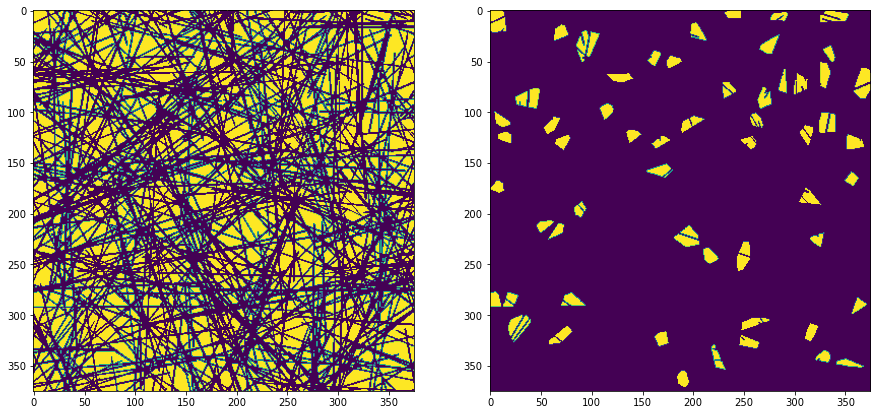

In [79]:
plt_cc(img_cc,100,200)